# Common imports

In [56]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

In [57]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 5)

# Provided functions
### Image loading and saving

In [58]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [59]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [60]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [61]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [62]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    imarray = imarray - ambimage[:,:,np.newaxis]
    cell = imarray < 0
    imarray[cell] = 0
    processed_imarray = (imarray - np.min(imarray))/(np.max(imarray) - np.min(imarray))
    return processed_imarray

In [63]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h, w, n = np.shape(imarray)
    imarray = np.reshape(imarray, ((h*w),n)).T
    temp_surface = np.linalg.lstsq(light_dirs, imarray)[0]
    
    surface_normals = np.reshape(temp_surface.T, (h,w,3))
    albedo_image = np.linalg.norm(surface_normals, axis = 2)
  
    return albedo_image, surface_normals

In [99]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    h, w, sb = np.shape(surface_normals)
    fx = surface_normals[:,:,0]/surface_normals[:,:,2]
    fy = surface_normals[:,:,1]/surface_normals[:,:,2]
    
    height_map_column = np.cumsum(fy[:,0])[:,np.newaxis] + np.cumsum(fx, axis = 1)
    height_map_row = np.cumsum(fx[0,:])[np.newaxis,:] + np.cumsum(fy, axis = 0)
    height_map_average = (height_map_column + height_map_row) /2
    
    if integration_method == 'column':
        height_map = height_map_column
        return height_map
    elif integration_method == 'row':
        height_map = height_map_row
        return height_map
    elif integration_method == 'average':
        height_map = height_map_average
        return height_map
    def get_random_value():
        x = np.random.randint(0,h)
        y = np.random.randint(0,w)
        prob = np.random.rand()
        height_map = np.zeros((h,w))
        if prob>0.5:
            height_map[x:,:] = np.cumsum(fx[x,:])[np.newaxis,:] + np.cumsum(fy[x:,:], axis = 0)
            height_map[:x,:] = np.flip(np.cumsum(fx[x,:])[np.newaxis,:] 
                                       + np.cumsum(np.flip(fy[:x,:],axis=0), axis = 0),axis=0)
        else:
            height_map[:,y:] = np.cumsum(fy[:,y])[:,np.newaxis] + np.cumsum(fx[:,y:], axis = 1)
            height_map[:,:y] = np.flip(np.cumsum(fy[:,y])[:,np.newaxis] 
                                       + np.cumsum(np.flip(fx[:,:y],axis=1), axis = 1),axis=1)
        return height_map
    
    height_map_random = np.zeros((h,w)) 
    t = 10000
    for i in range(t):
        height_map_random += get_random_value()
    
    height_map = height_map_random /t
    return height_map

# Main function

In [104]:
root_path = 'croppedyale/'
subject_name = 'yaleB05'
integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, 'avere')
#height_map = np.zeros((5,5))
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/Users/mac/anaconda3/envs/py3_5/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


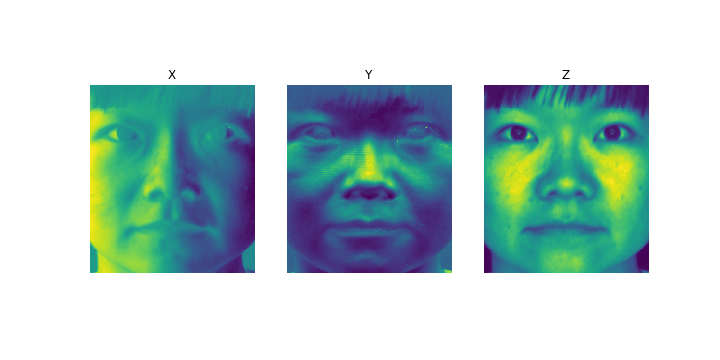

In [105]:
plot_surface_normals(surface_normals)

<IPython.core.display.Javascript object>


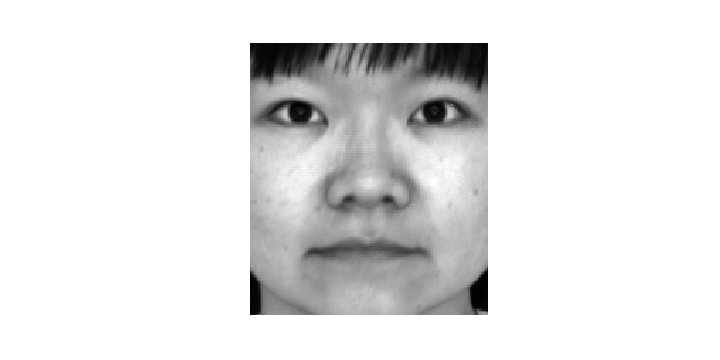

<IPython.core.display.Javascript object>


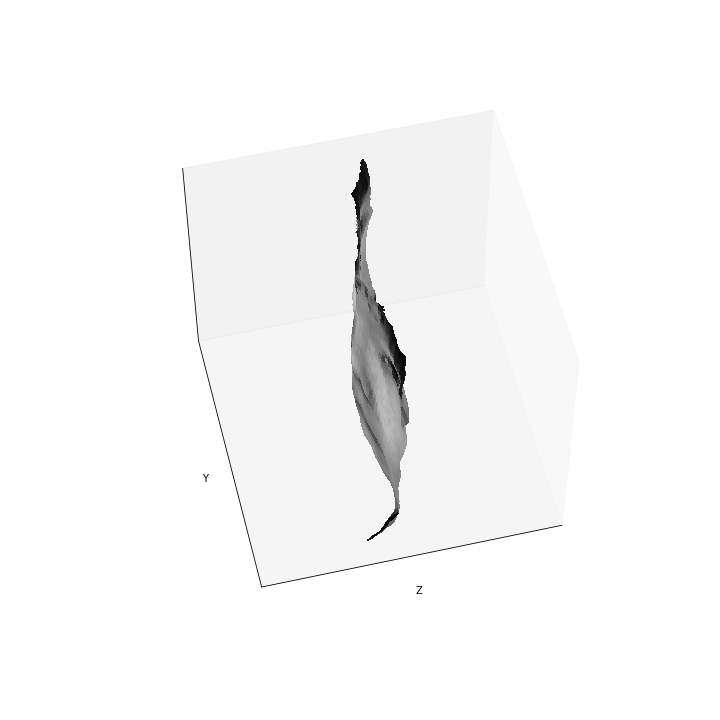

In [106]:
display_output(albedo_image, height_map)

In [68]:
a = np.random.randint(1,5)
a

4